In [2]:
!pip install psycopg2-binary

In [3]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
from getpass import getpass

In [4]:
db_host = '3.126.91.188'
db_name = 'timeseries_db'
db_user = 'postgres'

db_password = getpass(f"Enter password for PostgreSQL user '{db_user}': ")

Enter password for PostgreSQL user 'postgres':  ········


In [5]:
def db_connection_sql_query(db_host, db_name, db_user, db_password, sql_query):
    db_url = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:5432/{db_name}"
    
    try:
        engine = create_engine(db_url)
        print(f"Attempting to connect to {db_host}...")
        with engine.connect() as connection:
            
            df = pd.read_sql_query(sql_query, connection)
            print(f"Data fetched successfully with SQLAlchemy. Found {len(df)} rows.")

            return df
    
    except SQLAlchemyError as e:
        print(f"An error occurred with SQLAlchemy: {e}")
        return None # EXPLICIT RETURN: Return None on failure
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [6]:
sql_query_all_data = "SELECT * FROM sensor_data ORDER BY time ASC;"
df = db_connection_sql_query(db_host, db_name, db_user, db_password, sql_query_all_data)

Attempting to connect to 3.126.91.188...
Data fetched successfully with SQLAlchemy. Found 2312 rows.


Let's first check for missing values, we already did the preprocessing, but let's be sure that everything is fine

In [7]:
df.set_index('time', inplace=True)

In [8]:
print(df.isnull().sum())

no2            0
o3             0
pm10           0
pm25           0
month          0
day_of_week    0
is_weekend     0
pm10_roll_3    0
pm10_roll_7    0
no2_roll_3     0
no2_roll_7     0
o3_roll_3      0
o3_roll_7      0
dtype: int64


In [9]:
df.head(10)

,no2,o3,pm10,pm25,month,day_of_week,is_weekend,pm10_roll_3,pm10_roll_7,no2_roll_3,no2_roll_7,o3_roll_3,o3_roll_7
time,,,,,,,,,,,,,
2019-01-09 00:00:00+00:00,14.620000,49.360000,10.240000,7.330000,1,2,False,15.857315,15.141627,26.620556,18.672067,36.895000,43.812738
2019-01-10 00:00:00+00:00,15.468421,46.852632,11.764912,8.276316,1,3,False,15.056267,14.951892,24.650307,19.159818,37.827822,42.080376
2019-01-11 00:00:00+00:00,10.987500,39.650000,14.258333,13.200000,1,4,False,12.087749,14.469154,13.691974,18.301484,45.287544,40.837519
2019-01-12 00:00:00+00:00,26.582880,27.214130,15.540036,14.273913,1,5,True,13.854427,14.269516,17.679600,20.632805,37.905587,38.153823
2019-01-13 00:00:00+00:00,42.178261,14.778261,16.821739,15.347826,1,6,True,15.540036,15.136709,26.582880,25.011247,27.214130,34.168575
2019-01-14 00:00:00+00:00,29.508333,44.070833,8.199306,6.975000,1,0,False,13.520360,14.284031,32.756492,26.172557,28.687742,34.170956
2019-01-15 00:00:00+00:00,38.395833,28.345833,18.544444,14.077083,1,1,False,14.521830,13.624110,36.694143,25.391604,29.064976,35.753099
2019-01-16 00:00:00+00:00,50.787500,4.350000,30.329167,27.900000,1,2,False,19.024306,16.493991,39.563889,30.558390,25.588889,29.323099
2019-01-17 00:00:00+00:00,43.156522,33.991304,21.647917,19.161111,1,3,False,23.507176,17.905849,44.113285,34.513833,22.229046,27.485766


Now let's plot the data

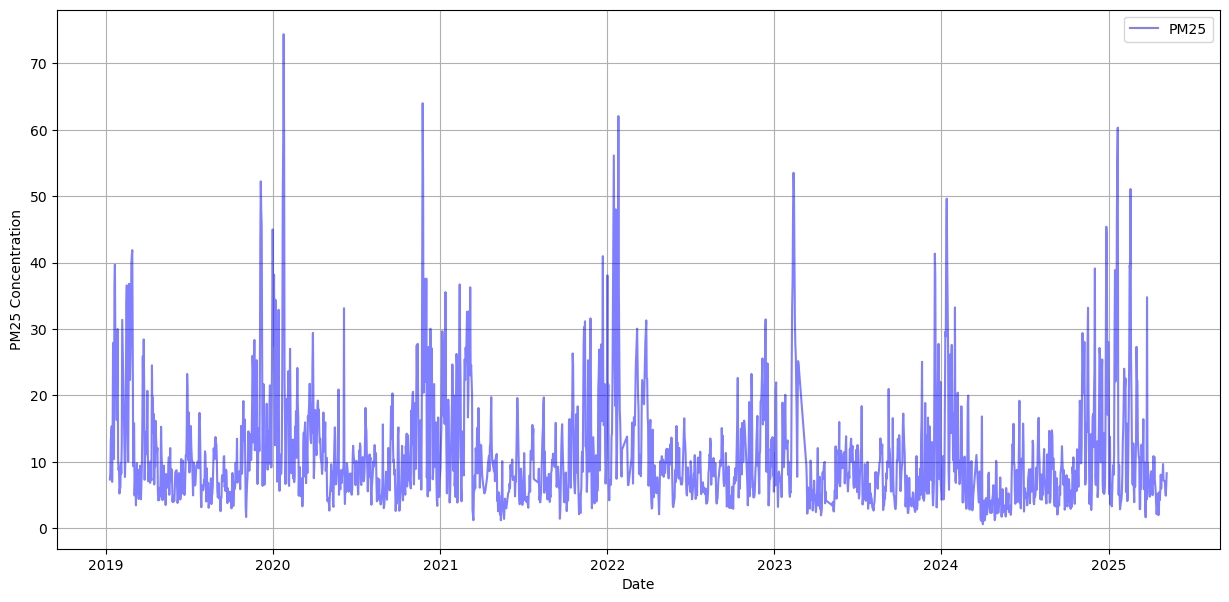

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 7))
plt.plot(df.index, df['pm25'], label='PM25', color='blue', alpha=0.5)
plt.ylabel('PM25 Concentration')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

Let's try to decompose this plot into a seasonal one with its trend, its seasonality and its residuals

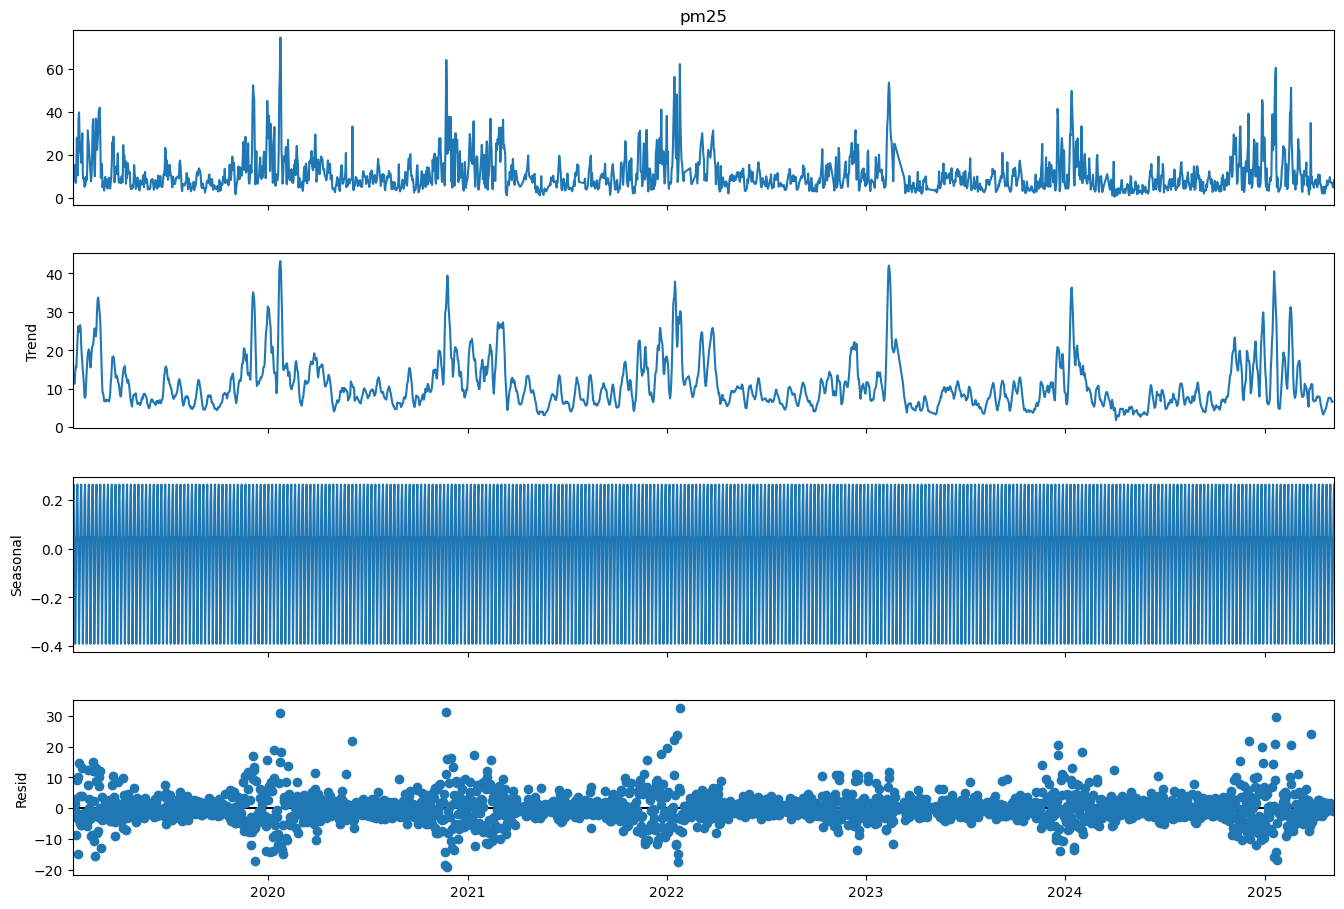

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

# The 'period' is crucial. It's the number of observations for a single seasonal cycle.
# If you have daily data and expect weekly seasonality, period=7.
# If you expect yearly seasonality with daily data, period=365.
result = seasonal_decompose(df['pm25'], model='additive', period=7) # Assuming daily data, yearly cycle

fig = result.plot()
fig.set_size_inches(15, 10)
plt.show()

We chose the seasonality as 7 days, which is what we expected to be, but the seasonality isn't readable, so let's focus on one week

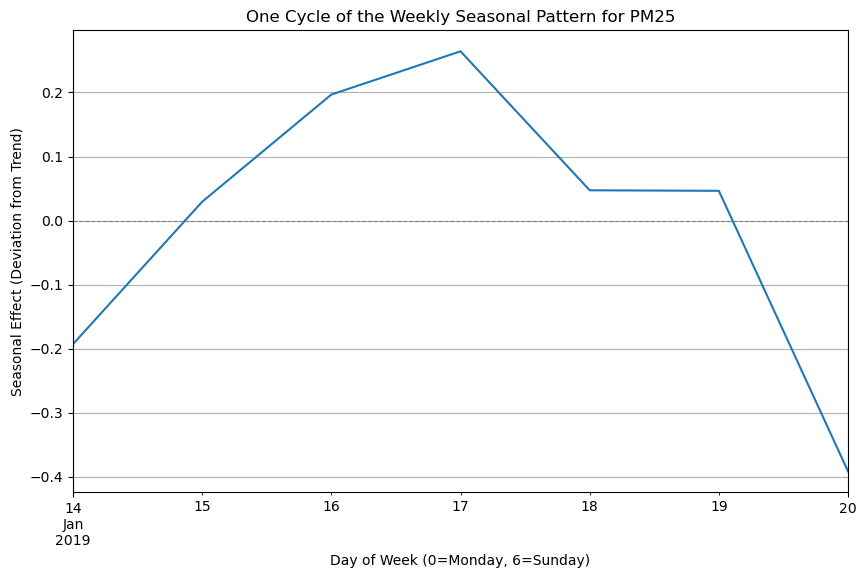

In [31]:
seasonal_component = result_decomposition.seasonal

plt.figure(figsize=(10, 6))

seasonal_component.iloc[5:12].plot()

plt.title('Cycles of the Weekly Seasonal Pattern for PM25')
plt.ylabel('Seasonal Effect (Deviation from Trend)')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.grid(True)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Add a zero line for reference
plt.show()

Let's check the result for all the datas and not only one week

Mean Seasonal Effect for Each Day:
time
0   -0.192828
1    0.029442
2    0.196792
3    0.264269
4    0.047315
5    0.046469
6   -0.391460
Name: seasonal, dtype: float64


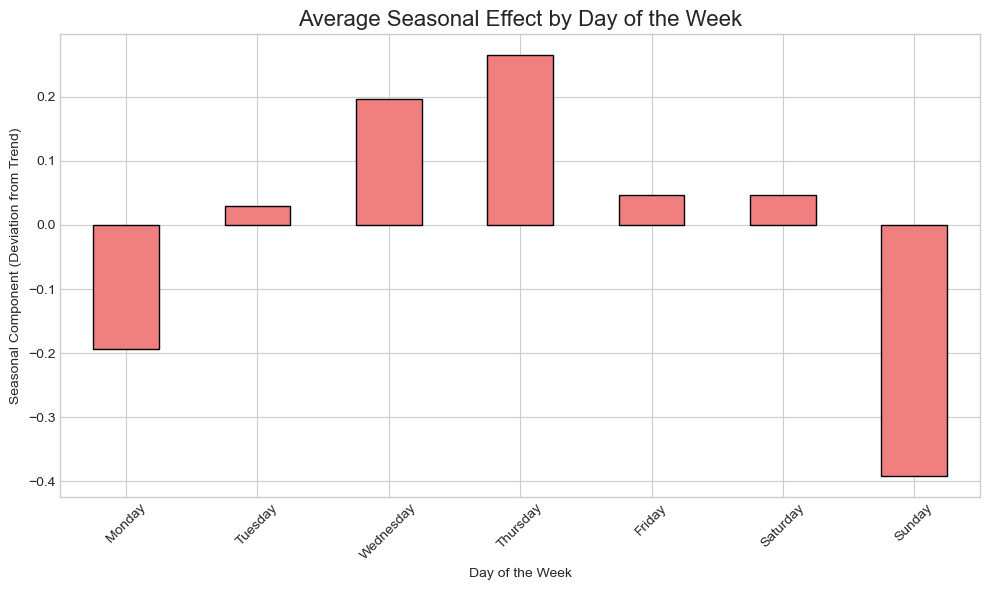

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

seasonal_component = result_decomposition.seasonal

mean_seasonal_effect_by_day = seasonal_component.groupby(seasonal_component.index.dayofweek).mean()

print("Mean Seasonal Effect for Each Day:")
print(mean_seasonal_effect_by_day)


plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

mean_seasonal_effect_by_day.plot(kind='bar', ax=ax, color='lightcoral', ec='black')

ax.set_title('Average Seasonal Effect by Day of the Week', fontsize=16)
ax.set_ylabel('Seasonal Component (Deviation from Trend)')
ax.set_xlabel('Day of the Week')


day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax.set_xticklabels(day_names, rotation=45)

plt.tight_layout()
plt.show()


The data clearly shows a strong weekly seasonal pattern in PM2.5 levels. The pollution cycle is heavily influenced by the typical work week, with levels building from Tuesday (+0.025) to a peak on Thursday (+0.25 above the trend). The levels then decline significantly over the weekend, hitting their lowest point on Sunday (-0.4 below the trend). This distinct pattern, with a total swing of 0.65 units, strongly suggests that PM2.5 levels are tied to human activity like commuter traffic and industrial operations, which are highest during the week and lowest on Sunday.

Let's now check for stationarity.

In [40]:
from statsmodels.tsa.stattools import adfuller

if df is not None and not df['no2'].isnull().all():
    result_adf = adfuller(df['no2'].dropna())
    print(f'ADF Statistic: {result_adf[0]}')
    print(f'p-value: {result_adf[1]}')
    # print('Critical Values:')
    # for key, value in result_adf[4].items():
    #     print(f'\t{key}: {value}')
    if result_adf[1] <= 0.05:
        print("Strong evidence against the null hypothesis (H0), reject H0. Data is likely stationary.")
    else:
        print("Weak evidence against null hypothesis, fail to reject H0. Data is likely non-stationary.")

ADF Statistic: -3.9674991091517935
p-value: 0.0015905906840079935
Strong evidence against the null hypothesis (H0), reject H0. Data is likely stationary.


We can now plot the ACF and PACF to determine which model to use

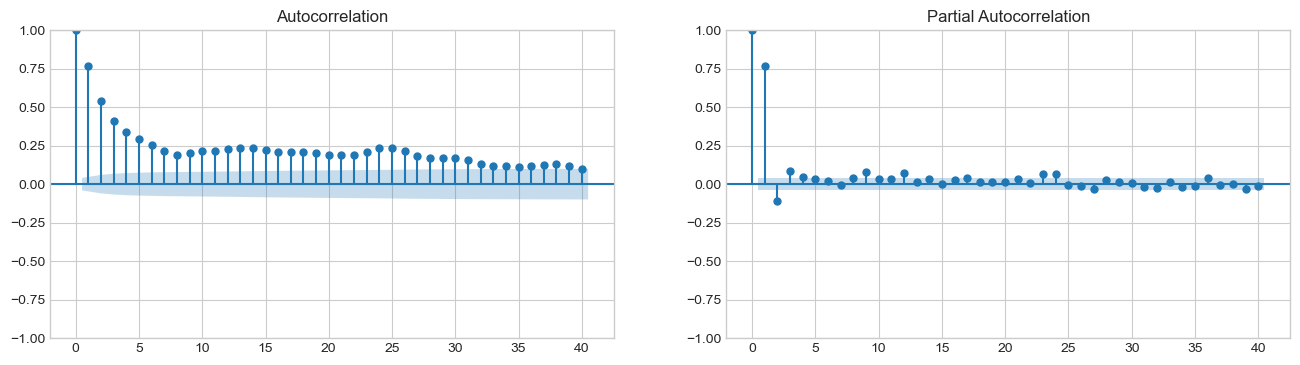

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

if df is not None and not df['pm25'].isnull().all():
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(df['pm25'].dropna(), ax=ax[0], lags=40) # Show up to 40 lags
    plot_pacf(df['pm25'].dropna(), ax=ax[1], lags=40)
    plt.show()

The PACF cuts off sharply after 2 lags, and the ACF tails off gradually, we will then use an autoregressive model.

Let's go for SARIMAX to use all of our variables.

In [43]:
# Target variable definition
target_variable = 'pm25'
endog = df[target_variable]

# 2. Predictor variables definition
exog_cols = [col for col in df.columns if col != target_variable]
exog = df[exog_cols]

print("Target variable (endog) shape:", endog.shape)
print("Predictor variables (exog) shape:", exog.shape)

Target variable (endog) shape: (2312,)
Predictor variables (exog) shape: (2312, 12)


Now for SARIMAX, we need to determine the model orders (p, d, q) and (P, D, Q, s).

In [44]:
pip install pmdarima

   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   - ------------------------------------- 30.7/614.7 kB 640.0 kB/s eta 0:00:01
   ------------------------------- -------- 481.3/614.7 kB 6.0 MB/s eta 0:00:01
   ---------------------------------------- 614.7/614.7 kB 5.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------  2.7/2.7 MB 56.9 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 42.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [45]:
import pmdarima as pm

# The auto_arima function will find the best (p,d,q)(P,D,Q,s) for you
# It requires the target variable (endog) and can optionally take the predictors (exog)
auto_model = pm.auto_arima(endog, 
                           exogenous=exog,
                           start_p=1, start_q=1,
                           test='adf',       # use adf test to find optimal 'd'
                           max_p=3, max_q=3, # maximum p and q
                           m=7,              # frequency of series (s)
                           d=None,           # let model determine 'd'
                           seasonal=True,   # Seasonality is present
                           start_P=0, 
                           D=None,           # let model determine 'D'
                           trace=True,       # prints status of the fits
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)    # use stepwise algorithm to find best model

print(auto_model.summary())

# The summary will give you the best order, e.g., SARIMAX(1, 0, 1)x(1, 0, 1, 7)
# You can then use these orders in the next step.

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=14319.708, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=16389.917, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=14350.490, Time=0.53 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=14959.249, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=18714.544, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=14317.969, Time=0.29 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=14319.677, Time=0.80 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=14314.456, Time=2.52 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=14311.995, Time=2.94 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=14313.560, Time=1.73 sec
 ARIMA(1,0,1)(2,0,2)[7] intercept   : AIC=14308.692, Time=5.44 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=14311.675, Time=2.26 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=14862.430, Time=5.09 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=4.63 sec
 ARIMA(2,0,1)(2,0,2)[7] i

Now we split the data into training and test set

In [46]:
train_size = int(len(df) * 0.8)

endog_train, endog_test = endog.iloc[:train_size], endog.iloc[train_size:]
exog_train, exog_test = exog.iloc[:train_size], exog.iloc[train_size:]

print("Training set size:", len(endog_train))
print("Test set size:", len(endog_test))

Training set size: 1849
Test set size: 463


In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

endog_train = endog_train.astype('float64')
exog_train = exog_train.astype('float64')
print("Conversion complete.")

print("Fitting SARIMAX model...")
p, d, q = 1, 0, 3
P, D, Q, s = 2, 0, 2, 7

model = SARIMAX(endog_train,
                exog=exog_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

print(results.summary())

Conversion complete.
Fitting SARIMAX model...


C:\Users\camil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\camil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:                                   pm25   No. Observations:                 1849
Model:             SARIMAX(1, 0, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -4665.632
Date:                                Tue, 01 Jul 2025   AIC                           9373.264
Time:                                        00:51:54   BIC                           9489.029
Sample:                                    01-09-2019   HQIC                          9415.961
                                         - 01-31-2024                                         
Covariance Type:                                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
no2             0.0896      0.013      6.660      0.000       0.063       0.116


C:\Users\camil\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


It doesn't seem that the model managed to converge.

Let's try to standardize the data.

In [52]:
from sklearn.preprocessing import StandardScaler

endog_scaler = StandardScaler()
exog_scaler = StandardScaler()

# Fit scaler ONLY on training data
endog_train_scaled = endog_scaler.fit_transform(endog_train.values.reshape(-1, 1))
exog_train_scaled = exog_scaler.fit_transform(exog_train)

# Transform the test data using the scaler fitted on the training data
endog_test_scaled = endog_scaler.transform(endog_test.values.reshape(-1, 1))
exog_test_scaled = exog_scaler.transform(exog_test)


# Fit the model with scaled data
model_scaled = SARIMAX(endog_train_scaled,
                       exog=exog_train_scaled,
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, s))

results_scaled = model_scaled.fit() 
print(results_scaled.summary())


                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 1849
Model:             SARIMAX(1, 0, 3)x(2, 0, [1, 2], 7)   Log Likelihood                -782.076
Date:                                Tue, 01 Jul 2025   AIC                           1606.152
Time:                                        01:09:05   BIC                           1722.122
Sample:                                             0   HQIC                          1648.903
                                               - 1849                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1263      0.019      6.588      0.000       0.089       0.164
x2 

C:\Users\camil\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Let's try with more attempt to find a solution.

In [53]:
model_scaled = SARIMAX(endog_train_scaled,
                       exog=exog_train_scaled,
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, s))

try:
    results = model_scaled.fit(maxiter=250, disp=False)
    print(results.summary())
except Exception as e:
    print(f"Failed with maxiter=250. Error: {e}")

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 1849
Model:             SARIMAX(1, 0, 3)x(2, 0, [1, 2], 7)   Log Likelihood                -781.922
Date:                                Tue, 01 Jul 2025   AIC                           1605.844
Time:                                        01:15:19   BIC                           1721.815
Sample:                                             0   HQIC                          1648.596
                                               - 1849                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1264      0.019      6.592      0.000       0.089       0.164
x2 

The model could be better, but let's evaluate its performance for now.

Checking data types of exog_test before conversion:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 463 entries, 2024-02-01 00:00:00+00:00 to 2025-05-08 00:00:00+00:00
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   no2          463 non-null    float64
 1   o3           463 non-null    float64
 2   pm10         463 non-null    float64
 3   month        463 non-null    int64  
 4   day_of_week  463 non-null    int64  
 5   is_weekend   463 non-null    bool   
 6   pm10_roll_3  463 non-null    float64
 7   pm10_roll_7  463 non-null    float64
 8   no2_roll_3   463 non-null    float64
 9   no2_roll_7   463 non-null    float64
 10  o3_roll_3    463 non-null    float64
 11  o3_roll_7    463 non-null    float64
dtypes: bool(1), float64(9), int64(2)
memory usage: 43.9 KB
None

Data types of exog_test AFTER conversion:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 463 entries, 2024-02-01 00:00:00+00:00 to 202

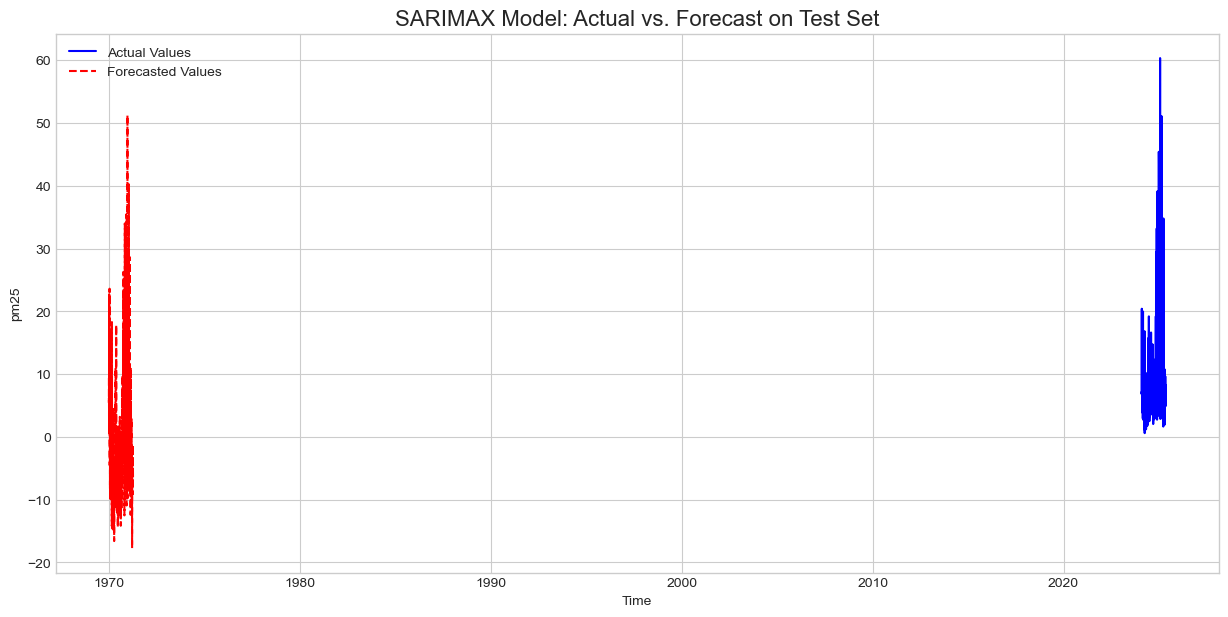

Root Mean Squared Error (RMSE) on the test set: 11.1853


In [56]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# This code assumes you have:
# - 'results': your fitted SARIMAX model
# - 'endog_test': your actual target values for the test period
# - 'exog_test': your predictor variables for the test period

# --- FIX: Ensure the test set predictors are also float64 ---
print("Checking data types of exog_test before conversion:")
print(exog_test.info()) # This will likely show bool, int64, or object dtypes

# Explicitly convert the entire exog_test DataFrame to float64
exog_test = exog_test.astype('float64')

print("\nData types of exog_test AFTER conversion:")
print(exog_test.info())
# --- End of Fix ---


# 1. Now, get the forecast with the correctly formatted exog_test
print("\nGenerating forecast...")
forecast_object = results.get_forecast(steps=len(endog_test), exog=exog_test)

# 2. Extract the predicted mean values
predicted_mean = forecast_object.predicted_mean

# 3. Plot the actual vs. predicted values
plt.figure(figsize=(15, 7))
plt.plot(endog_test, label='Actual Values', color='blue')
plt.plot(predicted_mean, label='Forecasted Values', color='red', linestyle='--')
plt.title('SARIMAX Model: Actual vs. Forecast on Test Set', fontsize=16)
plt.xlabel('Time')
plt.ylabel(endog_test.name)
plt.legend()
plt.grid(True)
plt.show()

# 4. Calculate an error metric
rmse = np.sqrt(mean_squared_error(endog_test, predicted_mean))
print(f"Root Mean Squared Error (RMSE) on the test set: {rmse:.4f}")